# 1D Heat equation; MLP

In [1]:
# initial plot
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import pandas as pd
from torch.utils.tensorboard import SummaryWriter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from PIL import Image

We will store the temperature u, at a given x,t in a 2D tensor called U(t,x)

In [2]:
# setup time-space geometry
num_points = 51
x_start = 0
x_stop = 1
num_timesteps = 1000
t_start = 0
t_stop = 1 

# 2D array to hold U(x,t)
x = np.linspace(start=x_start, stop=x_stop, num=num_points)
t = np.linspace(start=t_start, stop=t_stop, num=num_timesteps)
U = np.zeros((t.shape[0],x.shape[0]))
print(U.shape)

#Thermal diffusivity
alpha = 1.22e-3

#Numerical stability constraints
dx = x[1] - x[0] 
dt = 0.5 * dx**2 / alpha
sigma = alpha * dt / dx**2

#Intital conditions at t=0
U[0][:] = np.sin(np.pi * x)

# plot factor
plot_factor = int(np.floor(num_timesteps / 5))

(1000, 51)


In [3]:
def delta_heat(u):
    sigma = alpha * dt / dx**2
    return (sigma * (u[2:] - 2*u[1:-1] + u[:-2]))

plotting at timestep 0
plotting at timestep 200
plotting at timestep 400
plotting at timestep 600
plotting at timestep 800


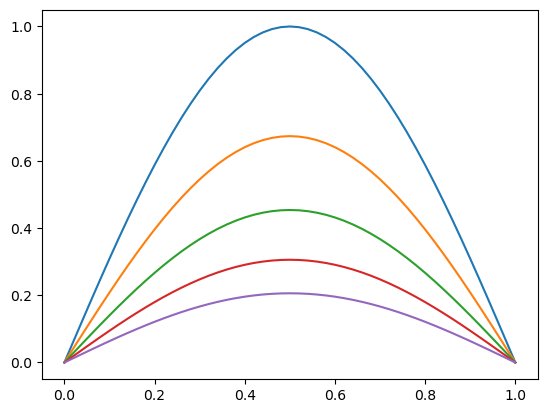

In [4]:
# evolve the heat over all timesteps
for tstep in range(len(t)):
    if tstep == 0:
        print(f"plotting at timestep 0")
        plt.plot(x,U[tstep][:])
        continue
    U[tstep][1:-1] = U[tstep-1][1:-1] + delta_heat(U[tstep-1][:])
    if tstep % plot_factor == 0:
        print(f"plotting at timestep {tstep}")
        plt.plot(x,U[tstep][:])

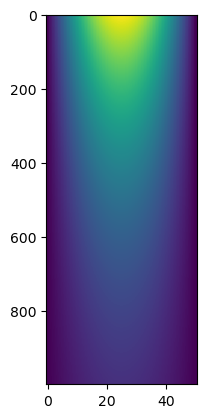

In [5]:
#Plot 2D heat diffusion using imshow
# - x axis is space
# - y axis is time
plt.imshow(U, aspect=0.125)

In [6]:
#Save numpy array to file to avoid having to recreate it every time
#Not a big deal here but will help when we extend to larger problem sizes
np.save("./1d-heat",U)

## Classic MLP Neural Network to learn the 1D-heat diffusion equation

The goal of the following section is to show the failure of MLP with no physics constraints

Prepare data for model tranining by extend the Dataset class to use our custom data \
Following this tutorial: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

- Use Dataset to store the samples and their corresponding labels
- DataLoader wraps an iterable around the Dataset to enable easy access to the samples

In [40]:
U_load = np.load("./1d-heat.npy")
print(U_load.shape)

(1000, 51)


In [44]:
plt.plot(U_load[0,:])


array([0.00000000e+00, 6.27905195e-02, 1.25333234e-01, 1.87381315e-01,
       2.48689887e-01, 3.09016994e-01, 3.68124553e-01, 4.25779292e-01,
       4.81753674e-01, 5.35826795e-01, 5.87785252e-01, 6.37423990e-01,
       6.84547106e-01, 7.28968627e-01, 7.70513243e-01, 8.09016994e-01,
       8.44327926e-01, 8.76306680e-01, 9.04827052e-01, 9.29776486e-01,
       9.51056516e-01, 9.68583161e-01, 9.82287251e-01, 9.92114701e-01,
       9.98026728e-01, 1.00000000e+00, 9.98026728e-01, 9.92114701e-01,
       9.82287251e-01, 9.68583161e-01, 9.51056516e-01, 9.29776486e-01,
       9.04827052e-01, 8.76306680e-01, 8.44327926e-01, 8.09016994e-01,
       7.70513243e-01, 7.28968627e-01, 6.84547106e-01, 6.37423990e-01,
       5.87785252e-01, 5.35826795e-01, 4.81753674e-01, 4.25779292e-01,
       3.68124553e-01, 3.09016994e-01, 2.48689887e-01, 1.87381315e-01,
       1.25333234e-01, 6.27905195e-02, 1.22464680e-16])

In [8]:
features = np.ones((U_load.shape[0]*U_load.shape[1],2))
features[:,1] = np.tile(x,U_load.shape[0])
features[:,0] = np.repeat(t,U_load.shape[1])
print(features[0:5])
print(features[-5:])

[[0.   0.  ]
 [0.   0.02]
 [0.   0.04]
 [0.   0.06]
 [0.   0.08]]
[[1.   0.92]
 [1.   0.94]
 [1.   0.96]
 [1.   0.98]
 [1.   1.  ]]


In [9]:
labels = np.ones((U_load.shape[0]*U_load.shape[1],1))
labels = U_load.ravel()
labels[0:5]

array([0.        , 0.06279052, 0.12533323, 0.18738131, 0.24868989])

In [10]:
features = features.astype(np.float32)
labels = labels.astype(np.float32)

At this point we have got our data from a saved file into two tensors.
A 1-D tensor of output temperatures and a 2D tensor of space (x) and time (t) input values.

Now we need to seperate training data from testing data. \
What else needs to happen....scale it? Cross-validation? How do these techniques fit into DNN?
Possivly use normalize as a transform that gets pased to the dataset class

In [11]:
### Pre-processing stage
std_scaler = StandardScaler()
scaler_features = std_scaler.fit(features)
scaled_features = scaler_features.transform(features)

print(f"\nPre-scaling:\n {features[0:5]}")
print(f"Mean: {features.mean()} Std: {features.std()}")
print(f"\nPost-scaling:\n {scaled_features[0:5]}")
print(f"Mean: {scaled_features.mean()} Std: {scaled_features.std()}")


Pre-scaling:
 [[0.   0.  ]
 [0.   0.02]
 [0.   0.04]
 [0.   0.06]
 [0.   0.08]]
Mean: 0.5000000596046448 Std: 0.2916906177997589

Post-scaling:
 [[-1.7303196 -1.6984155]
 [-1.7303196 -1.6304789]
 [-1.7303196 -1.5625423]
 [-1.7303196 -1.4946057]
 [-1.7303196 -1.426669 ]]
Mean: 2.1541818995274298e-08 Std: 1.0


In [75]:
colo_initial = 30
colo_boundary = 30
colo_interior_pts = int(0.2*(num_points * num_timesteps))

In [99]:
U.transpose().shape

(51, 1000)

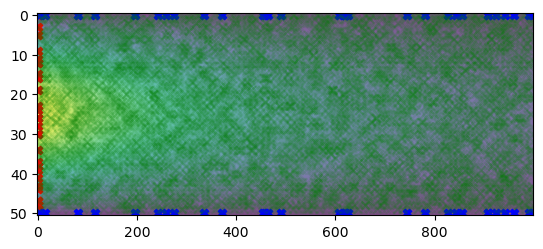

In [146]:
# Set random seed for reproducible results
np.random.seed(1234)

# Get a uniform sample locations for initial condition data
init_t_coord = np.ones((colo_initial,1), dtype=int).ravel() * 0
init_x_coord = np.random.randint(0, num_points-1, colo_initial)

#Plot initial condition locations in red:
plt.scatter(init_t_coord, init_x_coord, marker='X',c="red")

# Get a uniform sample location for left and right spatial boundary data
x0_bound_t_coord = np.random.randint(0, num_timesteps-1, colo_boundary)
x0_bound_x_coord = np.ones((colo_boundary,1), dtype=int).ravel() * 0
xstop_bound_t_coord = x0_bound_t_coord
xstop_bound_x_coord = np.ones((colo_boundary,1), dtype=int).ravel() * (num_points-1)

#Plot boundary condition locations in blue:
plt.scatter(x0_bound_t_coord, x0_bound_x_coord, marker='X',c="blue")
plt.scatter(xstop_bound_t_coord, xstop_bound_x_coord, marker='X',c="blue")

# Get a uniform sample location for interior data (80% of all remaining data)
x_interior_t_coord = np.random.randint(0,num_timesteps-1,colo_interior_pts)
x_interior_x_coord = np.random.randint(0,num_points-1,colo_interior_pts)

#Plot boundary condition locations in green:
plt.scatter(x_interior_t_coord, x_interior_x_coord, marker='x',c="green", alpha=0.1)

plt.imshow(U.transpose(), aspect=8, alpha=0.7)


Now use these colocation coordinates to extract training (and testing) data from simulated solution

In [147]:
U_load.shape

(1000, 51)

In [148]:
#Reshape locations into indexes to index into simulated data
init_data = U_load[init_t_coord,init_x_coord]
left_boundary_data = U_load[x0_bound_t_coord,x0_bound_x_coord]
right_boundary_data = U_load[xstop_bound_t_coord,xstop_bound_x_coord]
colo_data = U_load[x_interior_t_coord,x_interior_x_coord]

print(left_boundary_data.shape)
print(right_boundary_data.shape)
print(colo_data.shape)

(30,)
(30,)
(10200,)


In this next section I need to take the output from above and get it into a Dataset/DataLoader format to be used by the model

In [115]:
# Define MLP model architecture class
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = torch.nn.Flatten()
        self.linear_stack = torch.nn.Sequential(
            torch.nn.Linear(2, 64),
            torch.nn.Tanh(),
            torch.nn.Linear(64, 64),
            torch.nn.Tanh(),
            torch.nn.Linear(64, 64),
            torch.nn.Tanh(),
            torch.nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.linear_stack(x)
    
def train_loop(X,y, model, loss_fn, optimizer):
    pred = model(X)
    loss = loss_fn(pred, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

def test_loop(X,y, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss = 0

    with torch.no_grad():
        pred = model(X)
        test_loss += loss_fn(pred, y).item()

In [116]:
#Hyperparameters
learning_rates = [0.01,0.001,0.0001]
batch_sizes = [4]
optimizers = [torch.optim.SGD, torch.optim.Adam]
activation_functions = [torch.nn.Tanh, torch.nn.GELU, torch.nn.ReLU]
model_hidden_layers = [2]

In [117]:
for batch_size in batch_sizes:
    for learning_rate in learning_rates:

        model = NeuralNetwork()
        loss_fn = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        #Setup data for training
        X_train = 0
        y_train = 0

        epochs = 100
        for epoch in range(epochs):
            print(f"\nEpoch {epoch+1}\n-------------------------------")
            train_loop(X_train,y_train, model, loss_fn, optimizer)
        print("Training complete!\n")

        #Pass data for testing
        X_test = 0
        y_test = 0
        test_loop(X_test, y_test, model, loss_fn)
        print("Testing complete!\n")


Epoch 1
-------------------------------


/Users/harry/miniconda3/envs/pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([40800])) that is different to the input size (torch.Size([40800, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 0.142046  [40800/40800] Step:1/100

Epoch 2
-------------------------------
loss: 0.188064  [40800/40800] Step:2/100

Epoch 3
-------------------------------
loss: 0.056977  [40800/40800] Step:3/100

Epoch 4
-------------------------------
loss: 0.130642  [40800/40800] Step:4/100

Epoch 5
-------------------------------
loss: 0.074357  [40800/40800] Step:5/100

Epoch 6
-------------------------------
loss: 0.049570  [40800/40800] Step:6/100

Epoch 7
-------------------------------
loss: 0.065421  [40800/40800] Step:7/100

Epoch 8
-------------------------------
loss: 0.071021  [40800/40800] Step:8/100

Epoch 9
-------------------------------
loss: 0.058660  [40800/40800] Step:9/100

Epoch 10
-------------------------------
loss: 0.049302  [40800/40800] Step:10/100

Epoch 11
-------------------------------
loss: 0.051375  [40800/40800] Step:11/100

Epoch 12
-------------------------------
loss: 0.058811  [40800/40800] Step:12/100

Epoch 13
-------------------------------
loss: 0.0

/Users/harry/miniconda3/envs/pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10200])) that is different to the input size (torch.Size([10200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 0.158996  [40800/40800] Step:1/100

Epoch 2
-------------------------------
loss: 0.107375  [40800/40800] Step:2/100

Epoch 3
-------------------------------
loss: 0.072909  [40800/40800] Step:3/100

Epoch 4
-------------------------------
loss: 0.054075  [40800/40800] Step:4/100

Epoch 5
-------------------------------
loss: 0.048828  [40800/40800] Step:5/100

Epoch 6
-------------------------------
loss: 0.053338  [40800/40800] Step:6/100

Epoch 7
-------------------------------
loss: 0.061269  [40800/40800] Step:7/100

Epoch 8
-------------------------------
loss: 0.066644  [40800/40800] Step:8/100

Epoch 9
-------------------------------
loss: 0.067325  [40800/40800] Step:9/100

Epoch 10
-------------------------------
loss: 0.064270  [40800/40800] Step:10/100

Epoch 11
-------------------------------
loss: 0.059456  [40800/40800] Step:11/100

Epoch 12
-------------------------------
loss: 0.054664  [40800/40800] Step:12/100

Epoch 13
-------------------------------
loss: 0.0

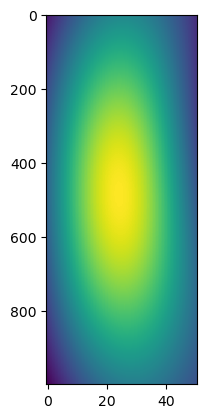

In [118]:
### INFERENCING STEP ###
with torch.inference_mode():
    prediction = model(torch.Tensor(scaled_features))

plt.imshow(prediction.reshape_as(torch.Tensor(U)), aspect=0.125)

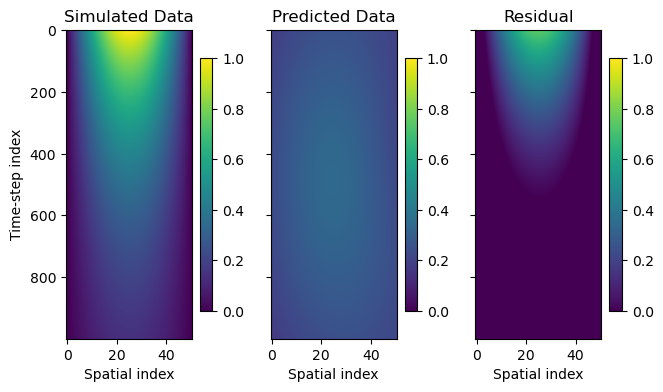

In [119]:
def result_plot(simulation, prediction):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
    f.tight_layout()

    # Min and max of real data so plots share limits
    sim_min = np.min(simulation)
    sim_max = np.max(simulation)
    
    sim_im = ax1.imshow(simulation, aspect=0.125, vmin=sim_min, vmax=sim_max)
    pred_im = ax2.imshow(prediction, aspect=0.125, vmin=sim_min, vmax=sim_max)
    res_im = ax3.imshow(simulation-np.asarray(prediction), aspect=0.125, vmin=sim_min, vmax=sim_max)

    # Colorbars
    f.colorbar(sim_im, orientation='vertical', shrink=0.6)
    f.colorbar(pred_im, orientation='vertical', shrink=0.6)
    f.colorbar(res_im, orientation='vertical', shrink=0.6)  
    
    #Titles and labels
    ax1.set_title("Simulated Data")
    ax1.set_ylabel("Time-step index")
    ax1.set_xlabel("Spatial index")
    ax2.set_title("Predicted Data")
    ax2.set_xlabel("Spatial index")
    ax3.set_title("Residual")
    ax3.set_xlabel("Spatial index")
    
    # Make spacing suitable
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)
    f.savefig("output_img.png")

prediction = prediction.reshape_as(torch.Tensor(U))
simulation = U
result_plot(simulation,prediction)